In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.util import ngrams
from nltk.stem import SnowballStemmer

from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def crear_df(filename, presi = False):
    with open(filename,"r", encoding="utf8") as file:
        lines = file.read()    

    lines = lines.split("\n")
    
    document = []
    line_erasers = ["LENO","\x0c","úm. 14","XI LEGISLATURA","DSPA_11_014","Pág.","2 de mayo de 2019","11-19/CAU-000001","11-19"]
    take_out_words = ["\n","—","PLENO"]

    for l in lines:
        insert = True
        for word in take_out_words:
            l = l.replace(word,"")
        for eraser in line_erasers:
            if eraser in l:
                insert = False
        if insert:
            document.append(l)
        
    d = {'texto': [], 'nombre': [], 'partido': [], 'ideologia': [], 'ntoken': []}

    df = pd.read_csv("partidos.csv",delimiter=";")

    key = ""
    i = 0
    texto = ""
    no_dialogo = True
    persona = ""
    inicio = None
    fin = None
    for n_pag,line in enumerate(document):
        if ("El señor" in line or "La señora" in line) and sum(map(str.isupper,line)) > 9 and sum(map(str.islower,line)) < 10:
            dialogo = True
            i+=1
            if i == 1:
                persona = line.strip("La señora ").strip("El señor ")
                persona = persona.split(",")
                if type(persona) == list:
                    persona = persona[0]
                inicio = n_pag
            else:
                fin = n_pag-1
                if (presi or persona != 'BOSQUET AZNAR'):
                    d['nombre'].append(persona)
                    d['texto'].append(texto)
                    d['ntoken'].append(len(texto.split(' ')))
                    d['partido'].append(df[df['persona'] == persona]['partido'].iloc[0])
                    d['ideologia'].append(df[df['persona'] == persona]['ideologia'].iloc[0])
    #             intervencion = Intervencion(persona,inicio,texto,fin)
                persona = line.strip("La señora ").strip("El señor ")
                persona = persona.split(",")
                if type(persona) == list:
                    persona = persona[0]
                if "ÓPEZ" == persona[0:4]:
                    persona = "L"+persona
                if "SPINOSA" == persona[0:7]:
                    persona = "E"+persona
                if "RAMIREZ DE ARELLANO" in persona:
                    persona = "RAMÍREZ DE ARELLANO"
                if "RAMÍREZ DE ARELLANO LÓPEZ" in persona:
                    persona = "RAMÍREZ DE ARELLANO"
                if "MORA GRAND" == persona:
                    persona = "MORA GRANDE"
                if "FERRIZ GOMEZ" == persona:
                    persona = "FÉRRIZ GÓMEZ"
                if "SEGOVIA BROM" == persona:
                    persona = "SEGOVIA BROME"
                if "OPIS" == persona[0:4]:
                    persona = "LL" + persona
                    
                inicio = n_pag
                texto = ""
    #             if not intervencion.persona in intervenciones.keys():
    #                 intervenciones[intervencion.persona] = [intervencion]
    #             else:
    #                 intervenciones[intervencion.persona].append(intervencion)
        else:
            if i > 0:
                if "11-19/DL-000001" in line or "DVOT-000012" in line:
                    dialogo = False
                if dialogo:
                    texto+=line + " "
                    
    return pd.DataFrame(data=d)

In [3]:
def getVectorize(stemmer = False, nGram = 2, stopWords = True):
    if stopWords:
        spanish_stopwords = stopwords.words('spanish')
    else:
        spanish_stopwords = []
        
    non_words = list(punctuation)
    non_words.extend(['¿', '¡'])
    non_words.extend(map(str,range(10)))

    def tokenize(text):
        text = ''.join([c for c in text if c not in non_words])
        tokens =  word_tokenize(text)
            
        s = []
        for n in range(1,nGram+1):
            for ngram in ngrams(tokens, n):
                s.append(' '.join(str(i) for i in ngram))

        return s
    
    if stemmer:
        stemmer = SnowballStemmer('spanish')
        analyzer = CountVectorizer().build_analyzer()

        def stemmed_words(doc):
            return (stemmer.stem(w) for w in analyzer(doc))
        
        return CountVectorizer(
                    analyzer = stemmed_words,
                    tokenizer = tokenize,
                    lowercase = True,
                    stop_words = spanish_stopwords)

    return CountVectorizer(
                    analyzer = 'word',
                    tokenizer = tokenize,
                    lowercase = True,
                    stop_words = spanish_stopwords)

In [4]:
def clasifyScore(X, y):
    scores = []
    models = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = MultinomialNB().fit(X_train, y_train)
    models.append(clf)
    scores.append(clf.score(X_test, y_test))
    clf = GaussianNB().fit(X_train.todense(), y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    clf = KNeighborsClassifier(n_neighbors = 8).fit(X_train, y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    clf = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    clf = SVC(kernel = 'linear').fit(X_train, y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    clf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0
                                ).fit(X_train, y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    
    return scores, models

In [5]:
def getXdata(metodo, ntoken = 0, stopWords = True, presi=False, vecto=False):
    data = crear_df('sumtext.txt', presi)
    data = data[data['ntoken']>=ntoken]
    
    if (metodo == 'Tf-idf'):
        counts = TfidfVectorizer().fit_transform(data['texto'])
    elif (metodo == 'Unigramas'):
        vectorizer = getVectorize(nGram = 1, stopWords=stopWords)
        counts = vectorizer.fit_transform(data['texto'])
    elif (metodo == 'Bigramas'):
        vectorizer = getVectorize(nGram = 2, stopWords=stopWords)
        counts = vectorizer.fit_transform(data['texto'])
    elif (metodo == 'Trigramas'):
        vectorizer = getVectorize(nGram = 3, stopWords=stopWords)
        counts = vectorizer.fit_transform(data['texto'])
    else:
        return []
    
    if vecto:
        return counts, data, vectorizer
        
    return counts, data

In [6]:
def getScores(d, dm, metodo, ntoken = 0, stopWords = True, presi=False):
    X, data = getXdata(metodo, ntoken, stopWords, presi)
    
    if ((not stopWords) and (metodo != 'Tf-idf')) :
        metodo += ' con stopwords'
    
    d['Nombre'][metodo], dm['Nombre'][metodo] = clasifyScore(X, data['nombre'])
    d['Partido'][metodo], dm['Partido'][metodo] = clasifyScore(X, data['partido'])
    d['Ideologia'][metodo], dm['Ideologia'][metodo] = clasifyScore(X, data['ideologia'])

In [7]:
def plotMetodo(d, caract, presi=False, ntoken=0):
    labels = ["MultinomialNB", "GaussianNB" ,"KNeighbors" ,"DecisionTree"
                  ,"LinearSVC" ,"RandomForest"]
    df = pd.DataFrame(data = d[caract], index=labels).T
    sns.heatmap(df,cmap="RdYlBu", linewidths=0.5, vmin=0, vmax =1, annot=True)
    plt.yticks(rotation=0) 
    title = 'Aciertos en el Clasificador de ' + caract + 's con ntoken='+str(ntoken)
    if presi:
        title += ' con president@'
    plt.title(title)
    plt.show()

In [8]:
def plotAll(presi=False, ntoken=0, stopwords=False):
    d ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
    dm ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
    
    
    %time getScores(d, dm, 'Tf-idf', presi=presi, ntoken=ntoken)
    %time getScores(d, dm, 'Unigramas', presi=presi, ntoken=ntoken)
    %time getScores(d, dm, 'Bigramas', presi=presi, ntoken=ntoken)
    %time getScores(d, dm, 'Trigramas', presi=presi, ntoken=ntoken)
    
    if stopwords:
        %time getScores(d, dm, 'Unigramas', stopWords=False, presi=presi, ntoken=ntoken)
        %time getScores(d, dm, 'Bigramas', stopWords=False, presi=presi, ntoken=ntoken)
        %time getScores(d, dm, 'Trigramas', stopWords=False, presi=presi, ntoken=ntoken)

    plotMetodo(d,'Nombre', presi=presi, ntoken=ntoken)
    plotMetodo(d,'Partido', presi=presi, ntoken=ntoken)
    plotMetodo(d,'Ideologia', presi=presi, ntoken=ntoken)
    
    return dm

CPU times: user 3.65 s, sys: 960 ms, total: 4.61 s
Wall time: 4.61 s
CPU times: user 5.27 s, sys: 152 ms, total: 5.42 s
Wall time: 5.38 s
CPU times: user 18.4 s, sys: 7.22 s, total: 25.6 s
Wall time: 25.6 s
CPU times: user 45.3 s, sys: 19.7 s, total: 1min 4s
Wall time: 1min 4s


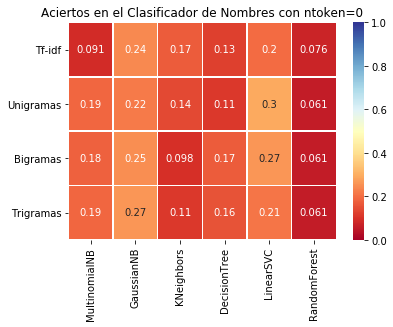

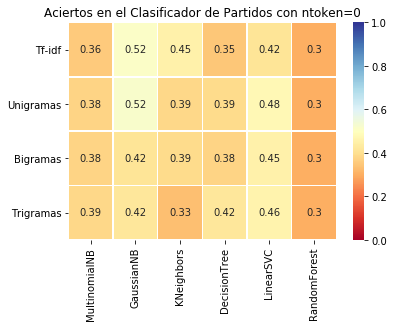

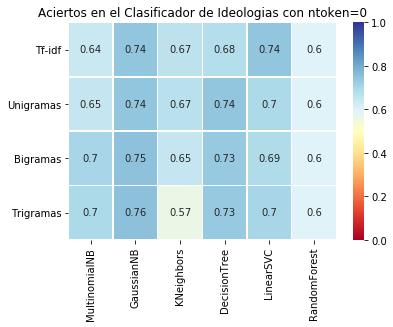

In [9]:
dm = plotAll()

CPU times: user 3.56 s, sys: 152 ms, total: 3.72 s
Wall time: 3.7 s
CPU times: user 5.27 s, sys: 133 ms, total: 5.4 s
Wall time: 5.36 s
CPU times: user 17.5 s, sys: 6.21 s, total: 23.7 s
Wall time: 23.7 s
CPU times: user 36.7 s, sys: 15.2 s, total: 51.9 s
Wall time: 51.9 s


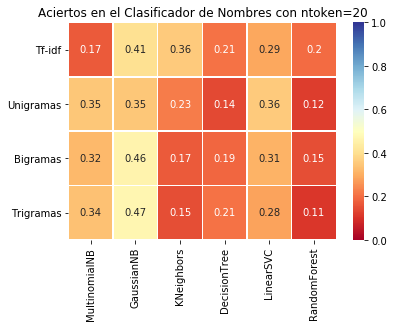

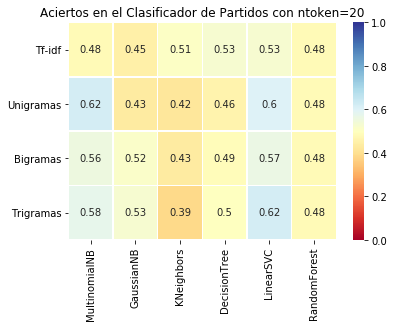

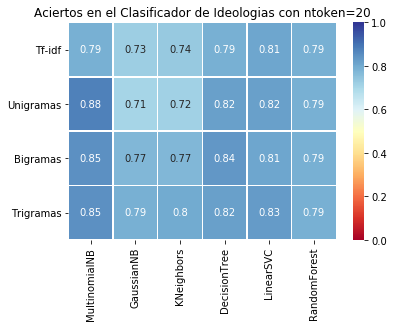

In [10]:
dm = plotAll(ntoken=20)

CPU times: user 3.44 s, sys: 595 µs, total: 3.44 s
Wall time: 3.53 s
CPU times: user 4.81 s, sys: 13 ms, total: 4.82 s
Wall time: 4.81 s
CPU times: user 17 s, sys: 6.14 s, total: 23.1 s
Wall time: 23.1 s
CPU times: user 40.4 s, sys: 16 s, total: 56.4 s
Wall time: 56.4 s
CPU times: user 5.04 s, sys: 119 ms, total: 5.16 s
Wall time: 5.13 s
CPU times: user 15.9 s, sys: 5.55 s, total: 21.5 s
Wall time: 21.4 s
CPU times: user 37.3 s, sys: 15.9 s, total: 53.3 s
Wall time: 2min


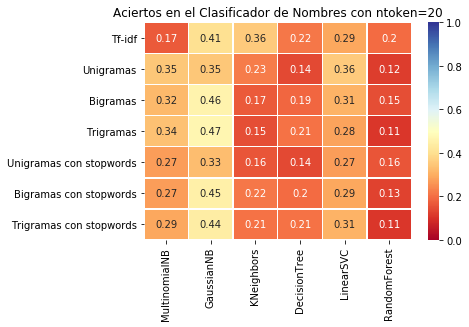

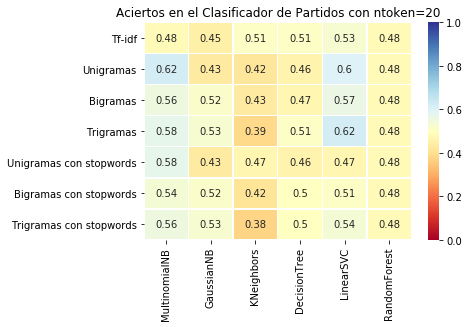

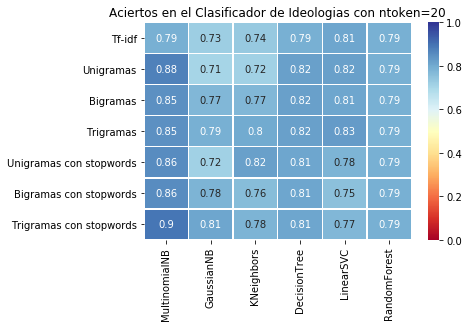

In [11]:
dm = plotAll(ntoken=20, stopwords=True)

In [12]:
def getRelevantes(vectorizer, clf, modelo, n=20):
    if modelo == "MultinomialNB":
        feature_names = vectorizer.get_feature_names()
        coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
        top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
        print("%-23s   %-23s" % ('Términos menos relvantes', 'Términos más relvantes'))
        print()
        for (coef_1, fn_1), (coef_2, fn_2) in top:
            print("%.4f  %-15s  %.4f  %-15s" % (coef_1, fn_1, coef_2, fn_2))

In [13]:
def confMatrix(caract, metodo, modelo, dm = {}, ntoken=20):
    if not dm:
        d ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
        dm ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
        getScores(d, dm, metodo, ntoken=ntoken)
        
    labels = ["MultinomialNB", "GaussianNB" ,"KNeighbors" ,"DecisionTree"
                  ,"LinearSVC" ,"RandomForest"]
    
    X, data, vectorizer = getXdata(metodo, ntoken=ntoken, vecto=True)
    
    clf = dm[caract][metodo][labels.index(modelo)]
    X_train, X_test, y_train, y_test = train_test_split(X, data[caract.lower()], random_state=0)
    
    getRelevantes(vectorizer, clf, modelo)
    
    y_pred = clf.predict(X_test)
    labels= list(set(data[caract.lower()]))
    conf_mat = confusion_matrix(y_test.tolist(), y_pred.tolist(),labels )
    sns.heatmap(conf_mat, linewidths=0.5, fmt='g', annot=True, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predición')
    plt.ylabel('Test')
    plt.title('Matriz de confusión para '+caract+'s con '+metodo+', '+modelo+' y ntoken='+str(ntoken))

Términos menos relvantes   Términos más relvantes 

-10.3477  abanderamos      -5.3304  ustedes        
-10.3477  abanderarlo      -5.4350  andalucía      
-10.3477  abandonada       -5.6843  ley            
-10.3477  abandonan        -5.7227  si             
-10.3477  abandonar        -5.7425  gobierno       
-10.3477  abandonen        -6.0436  ser            
-10.3477  abarca           -6.0850  usted          
-10.3477  abarque          -6.1282  va             
-10.3477  abascal          -6.2046  aquí           
-10.3477  abastecimientos  -6.2206  solo           
-10.3477  abc              -6.2206  además         
-10.3477  aberraciones     -6.2533  señora         
-10.3477  abiertos         -6.2533  gracias        
-10.3477  abismal          -6.3046  sector         
-10.3477  abismo           -6.3046  partido        
-10.3477  abocada          -6.3223  muchas         
-10.3477  abocadas         -6.3587  sistema        
-10.3477  abocado          -6.3774  personas       
-10.3477  ab

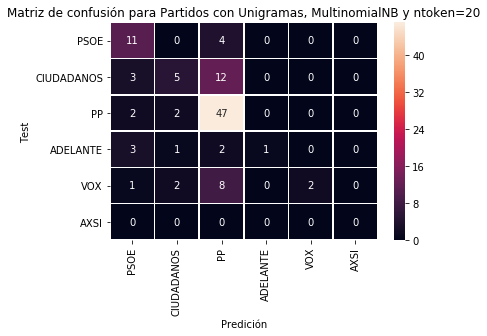

In [14]:
confMatrix('Partido','Unigramas', "MultinomialNB", dm)

Términos menos relvantes   Términos más relvantes 

-10.8710  abanderarlo      -4.8331  andalucía      
-10.8710  abandonada       -4.8427  ustedes        
-10.8710  abandonan        -5.0188  gobierno       
-10.8710  abandonen        -5.1806  usted          
-10.8710  abarque          -5.4286  si             
-10.8710  abc              -5.4683  señor          
-10.8710  aberraciones     -5.4728  ley            
-10.8710  abismal          -5.6949  partido        
-10.8710  abismo           -5.7711  grupo          
-10.8710  abocada          -5.8738  gracias        
-10.8710  abogacía         -5.8874  aquí           
-10.8710  abonada          -5.9012  ser            
-10.8710  abonado          -5.9152  personas       
-10.8710  abone            -5.9152  años           
-10.8710  abonó            -5.9294  señora         
-10.8710  abor             -5.9510  socialista     
-10.8710  aborda           -5.9807  va             
-10.8710  abordada         -6.0035  además         
-10.8710  ab

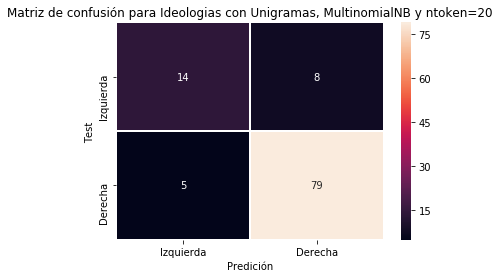

In [15]:
confMatrix('Ideologia','Unigramas', "MultinomialNB", dm)

Términos menos relvantes   Términos más relvantes 

-13.1742  a a              -6.7397  de la          
-13.1742  a a esa          -7.1364  andalucía      
-13.1742  a abandonar      -7.1460  ustedes        
-13.1742  a abandonar sus  -7.3220  gobierno       
-13.1742  a abandonar una  -7.4312  de los         
-13.1742  a abordar        -7.4377  en el          
-13.1742  a abordar enfocándola  -7.4507  lo que         
-13.1742  a abordar enmiendas  -7.4839  usted          
-13.1742  a abordar la     -7.5359  que se         
-13.1742  a abordar vamos  -7.6408  a la           
-13.1742  a abordarlo      -7.6689  en la          
-13.1742  a abordarlo todo  -7.6853  que no         
-13.1742  a abrir al       -7.7318  si             
-13.1742  a abrir qué      -7.7493  de las         
-13.1742  a acabar pues    -7.7716  señor          
-13.1742  a acabar todos   -7.7761  ley            
-13.1742  a aceptar de     -7.9593  a los          
-13.1742  a aceptar estas  -7.9981  partido        
-

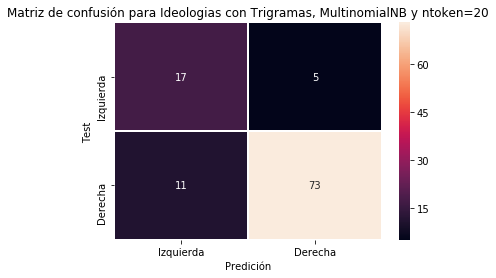

In [16]:
confMatrix('Ideologia','Trigramas', "MultinomialNB", dm)